In [1]:
import numpy as np
import cv2
import open3d as o3d
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import NearestNeighbors
import json
import math
import os
import random

%matplotlib inline

with open("calib/calib_data.json","r") as f:
    j = json.load(f)
j["cameraData"][0][1]
rgb_data=j["cameraData"][1][1]
left_data=j["cameraData"][2][1]
right_data=j["cameraData"][0][1]

directory=2

left_movie = cv2.VideoCapture(f'movie/{directory}/left.mp4')
right_movie = cv2.VideoCapture(f'movie/{directory}/right.mp4')
rgb_movie = cv2.VideoCapture(f'movie/{directory}/rgb.mp4')
disparity = cv2.VideoCapture(f'movie/{directory}/disparity.mp4')
confmap = cv2.VideoCapture(f'movie/{directory}/conf.mp4')

bl = 75 #mm base line
rcx = right_data["intrinsicMatrix"][0][2]
rcy = right_data["intrinsicMatrix"][1][2]
rfx = right_data["intrinsicMatrix"][0][0]
rfy = right_data["intrinsicMatrix"][1][1]

rgb_cx=rgb_data["intrinsicMatrix"][0][2]
rgb_cy=rgb_data["intrinsicMatrix"][1][2]
rgb_fx=rgb_data["intrinsicMatrix"][0][0]
rgb_fy=rgb_data["intrinsicMatrix"][1][1]

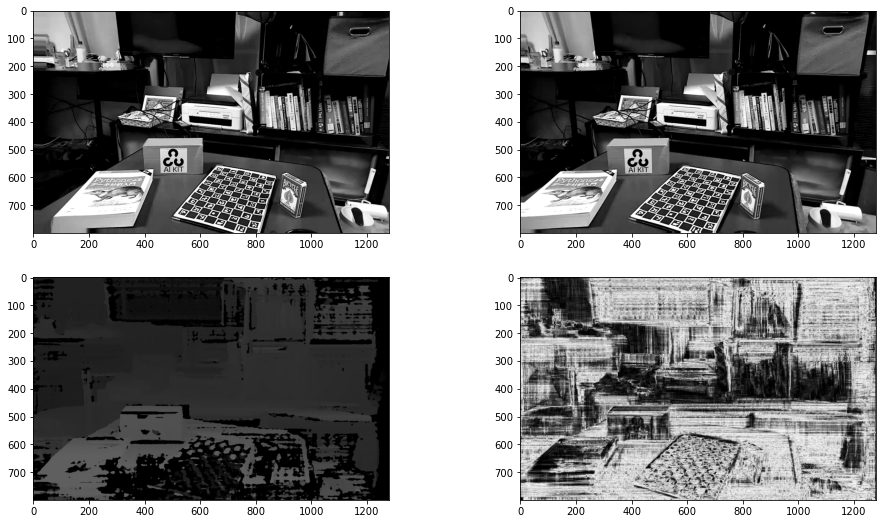

In [2]:
def getframes(frame_num,color=False,display=False):
    if color:
        rgb_movie.set(cv2.CAP_PROP_POS_FRAMES,frame_num)
        rgb_ret,rgb_frame = rgb_movie.read()
#       rgb_frame = cv2.undistort(rgb_frame,np.array(rgb_data["intrinsicMatrix"]),np.array(rgb_data['distortionCoeff']))
        rgb_frame = cv2.cvtColor(rgb_frame,cv2.COLOR_BGRA2RGB)
        if display:
            plt.figure(figsize=(16,9))
            plt.imshow(rgb_frame)
        return rgb_frame
    else:
        left_movie.set(cv2.CAP_PROP_POS_FRAMES,frame_num)
        right_movie.set(cv2.CAP_PROP_POS_FRAMES,frame_num)
        disparity.set(cv2.CAP_PROP_POS_FRAMES,frame_num)
        confmap.set(cv2.CAP_PROP_POS_FRAMES,frame_num)


        left_ret, left_frame = left_movie.read()
        right_ret, right_frame = right_movie.read()
        dis_ret,dis_frame = disparity.read()
        conf_ret,conf_frame = confmap.read()


        if display:
            plt.figure(figsize=(16,9))
            plt.subplot(221).imshow(left_frame)
            plt.subplot(222).imshow(right_frame)
            plt.subplot(223).imshow(dis_frame)
            plt.subplot(224).imshow(conf_frame)
            plt.show()
        return left_frame,right_frame,dis_frame,conf_frame


left_frame,right_frame,dis_frame,conf_frame =getframes(20,display=True)

In [31]:
sift=cv2.SIFT_create(nOctaveLayers=20,contrastThreshold=0.001,edgeThreshold =100)

58548


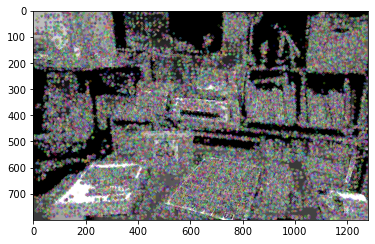

In [32]:
gl = cv2.cvtColor(left_frame,cv2.COLOR_BGR2GRAY)
kl,dl = sift.detectAndCompute(gl,None)
print(len(kl))
img=cv2.drawKeypoints(gl,kl,None)
plt.imshow(img)

59449


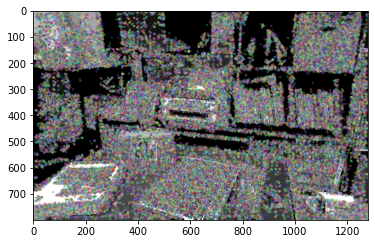

In [33]:
gr = cv2.cvtColor(right_frame,cv2.COLOR_BGR2GRAY)
kr,dr = sift.detectAndCompute(gr,None)
print(len(kr))
img=cv2.drawKeypoints(gr,kr,None)
plt.imshow(img)

In [6]:
%%time
feature_left_kp, feature_left_des = sift.detectAndCompute(left_frame, None)
feature_right_kp, feature_right_des = sift.detectAndCompute(right_frame, None)
feature_bf = cv2.BFMatcher()
feature_matches = feature_bf.knnMatch(feature_left_des, feature_right_des, k=5)

In [24]:
t = 5
for i in range(5):
    print(feature_left_kp[feature_matches[t][i].queryIdx].pt)
    print(feature_right_kp[feature_matches[t][i].trainIdx].pt)

(4.577925205230713, 507.4888000488281)
(265.9580383300781, 80.76472473144531)
(4.577925205230713, 507.4888000488281)
(5.5504608154296875, 662.4130859375)
(4.577925205230713, 507.4888000488281)
(481.1324157714844, 451.66925048828125)
(4.577925205230713, 507.4888000488281)
(92.52901458740234, 741.6948852539062)
(4.577925205230713, 507.4888000488281)
(40.74966812133789, 744.5916137695312)


21568 matches found


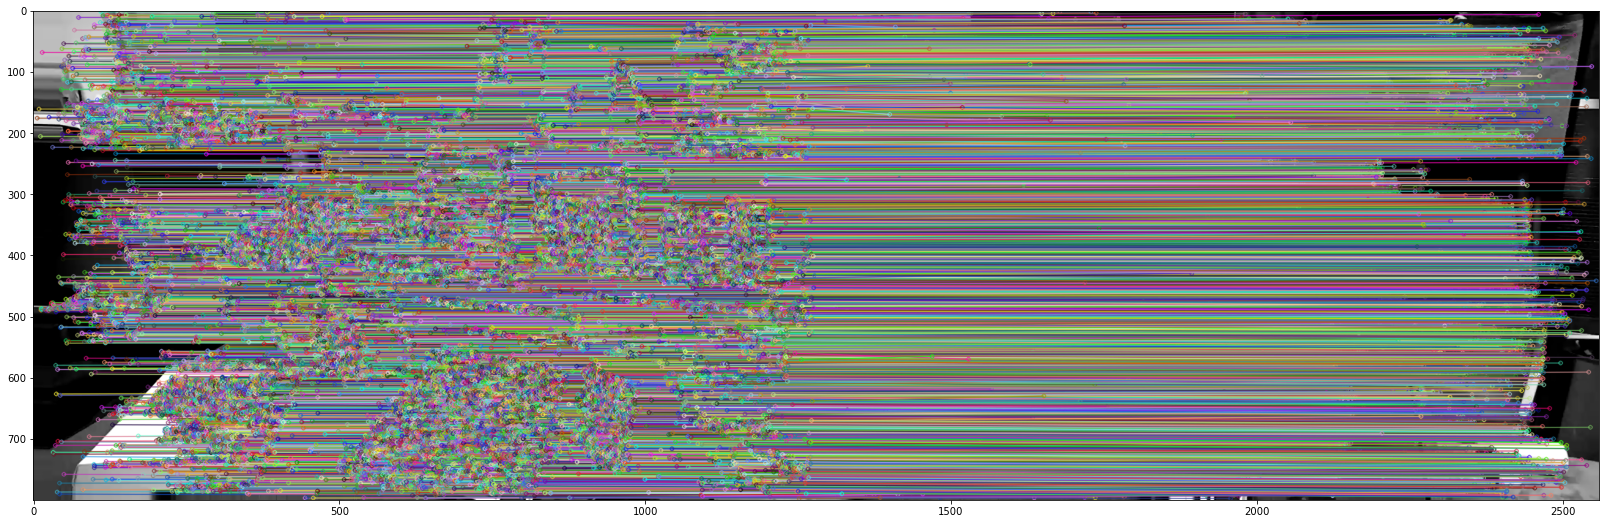

Wall time: 1min 28s


In [34]:
%%time
feature_left_kp, feature_left_des = sift.detectAndCompute(left_frame, None)
feature_right_kp, feature_right_des = sift.detectAndCompute(right_frame, None)

feature_bf = cv2.BFMatcher()

feature_matches = feature_bf.match(feature_left_des, feature_right_des)
feature_matches = [i for i in feature_matches if abs(feature_left_kp[i.queryIdx].pt[1]-feature_right_kp[i.trainIdx].pt[1])<10]
print(len(feature_matches),"matches found")

img_feature = cv2.drawMatches(left_frame, feature_left_kp, right_frame , feature_right_kp, feature_matches, None, flags=2)
plt.figure(figsize=(32,9))
plt.imshow(img_feature)
plt.show()

17250


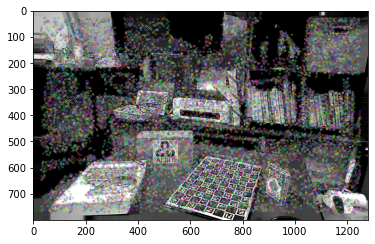

In [54]:
akaze = cv2.AKAZE_create(threshold=0.00000001)
gl = cv2.cvtColor(left_frame,cv2.COLOR_BGR2GRAY)
kl,dl = akaze.detectAndCompute(gl,None)
print(len(kl))
img=cv2.drawKeypoints(gl,kl,None)
plt.imshow(img)

In [ ]:
pt_y_l=[]
des_y_l=[]

pt_y_r=[]
des_y_r = []
step = 10
for i in range(0,right_data["height"],step):
    pt_y_li = [pt for pt in kl if pt.pt[1] >i and pt.pt[1] <=i+step]
    pt_y_li = [pt for pt in kl if pt.pt[1] >i and pt.pt[1] <=i+step]h

In [237]:
kl[0].pt

(2.3527684211730957, 168.52365112304688)

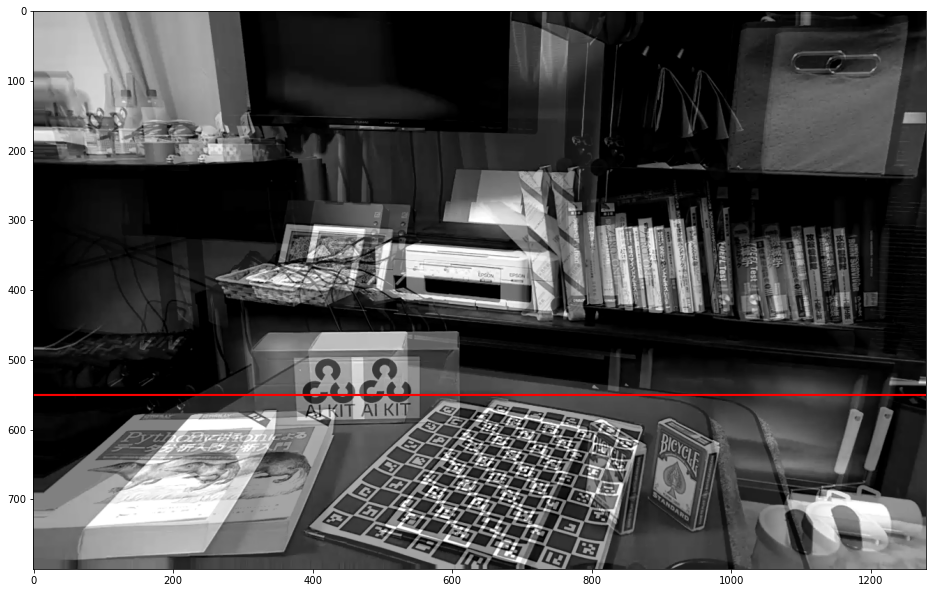

In [232]:
y =550
dst = cv2.addWeighted(left_frame, 0.5, right_frame, 0.5, 0)
dst= cv2.line(dst,(0,y),(1400,y),(255,0,0),2)
plt.figure(figsize=(16,32))
plt.imshow(dst)